In [53]:
#1- Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import sys

# Configuração para os gráficos ficarem profissionais
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [54]:
#2- Leitura CSV
f_reservas = pd.read_csv('f_reservas.csv')       
f_diarias = pd.read_csv('f_diarias.csv')         
f_reviews = pd.read_csv('f_reviews.csv')         
f_inventario = pd.read_csv('f_inventario_diario.csv') 
d_canal = pd.read_csv('d_canal.csv')             
d_hotel = pd.read_csv('d_hotel.csv') 

In [55]:
#3- Função para transformar números (YYYYMMDD) em datas reais
def formatar_data_humana(valor):
    try:
        return pd.to_datetime(str(int(valor)), format='%Y%m%d')
    except:
        return pd.NaT

In [56]:
#4- FAXINA E AUDITORIA (DATA QUALITY)
# Regra 1: Remover duplicatas
f_reservas.drop_duplicates(inplace=True)

# Regra 2: Preencher valores vazios com a Mediana
valor_central = f_reservas['valor_previsto'].median()
f_reservas['valor_previsto'] = f_reservas['valor_previsto'].fillna(valor_central)

# Regra 3: Notas válidas (1 a 10)
f_reviews = f_reviews.loc[(f_reviews['nota'] >= 1) & (f_reviews['nota'] <= 10)]

# Regra 4: Receitas positivas - Valors acima de zero reais
f_diarias = f_diarias.loc[f_diarias['receita_diarias'] >= 0]

In [57]:
#5: Limite de Outliers no ADR (Preço Diário) usando NumPy
array_precos = np.array(f_diarias['adr_estimado'])
Q1 = np.quantile(array_precos, 0.25)
Q3 = np.quantile(array_precos, 0.75)
IQR = Q3 - Q1
limite_superior_adr = Q3 + (1.5 * IQR)
print(f"Auditoria: Limite superior para ADR: R$ {limite_superior_adr:.2f}")

Auditoria: Limite superior para ADR: R$ 977.04


In [58]:
# Regra 6: Conferência de Overbooking
df_conferencia = pd.merge(f_diarias, f_inventario, on=['hotel_id', 'data_id', 'tipo_quarto'])
df_conferencia = pd.merge(df_conferencia, d_hotel, on='hotel_id')


In [59]:
#7- TRANSFORMANDO DADOS EM COMPORTAMENTO
f_reservas['data_reserva_limpa'] = f_reservas['data_reserva_id'].apply(formatar_data_humana)
f_reservas['data_checkin_limpa'] = f_reservas['checkin_id'].apply(formatar_data_humana)



In [60]:
#8- Cálculo do Lead Time (Antecedência)
f_reservas['lead_time'] = (f_reservas['data_checkin_limpa'] - f_reservas['data_reserva_limpa']).dt.days


In [61]:
# ----------------Graficos----------------
# Este trabalho analisa dados reais da rede Nara Hotels para entender reservas, cancelamentos, preços, ocupação e satisfação dos hóspedes

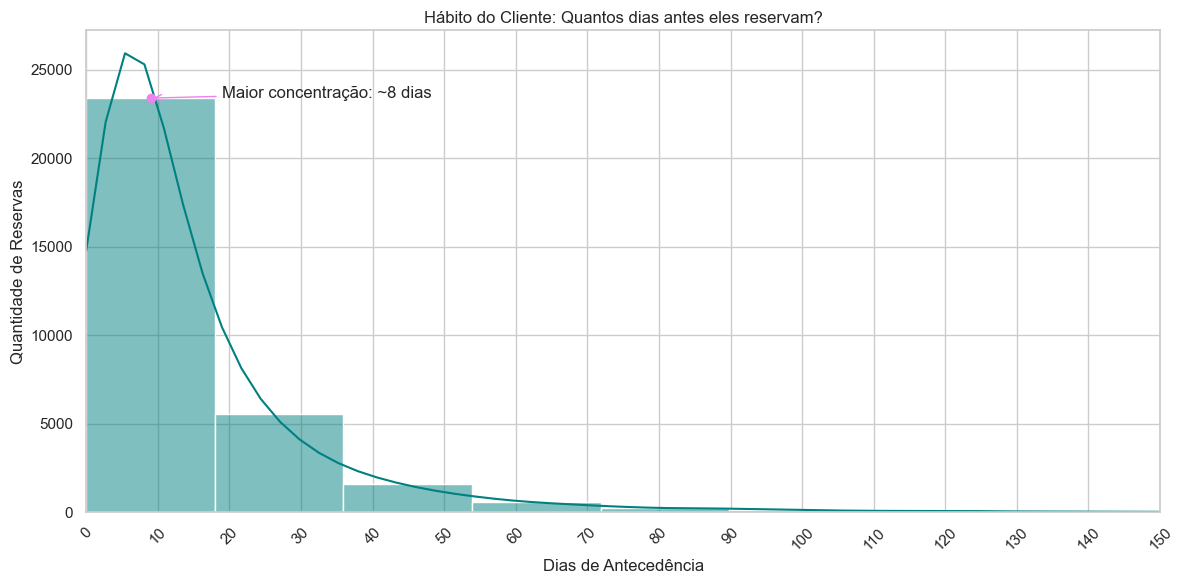

In [62]:
# Gráfico de Antecedência da Reserva
plt.figure()

# Histograma
sns.histplot(
    f_reservas['lead_time'],
    bins=30,
    kde=True,
    color='teal'
)

# Ajuste do eixo X (mais legível)
plt.xlim(0, 150)
plt.xticks(range(0, 151, 10), rotation=45)

# Cálculo do ponto de maior concentração de reservas
dados = f_reservas['lead_time'].dropna()
contagens, bins = np.histogram(dados, bins=30)

indice_max = contagens.argmax()
x_max = (bins[indice_max] + bins[indice_max + 1]) / 2
y_max = contagens[indice_max]

# Destaque do ponto máximo
plt.scatter(x_max, y_max, color='violet', zorder=5)
plt.annotate(
    f'Maior concentração: ~{int(x_max)} dias',
    xy=(x_max, y_max),
    xytext=(x_max + 10, y_max),
    arrowprops=dict(arrowstyle='->', color='violet')
)

# Títulos e rótulos
plt.title('Hábito do Cliente: Quantos dias antes eles reservam?')
plt.xlabel('Dias de Antecedência')
plt.ylabel('Quantidade de Reservas')

plt.tight_layout()
plt.savefig('grafico_1_leadtime.png')
plt.show()




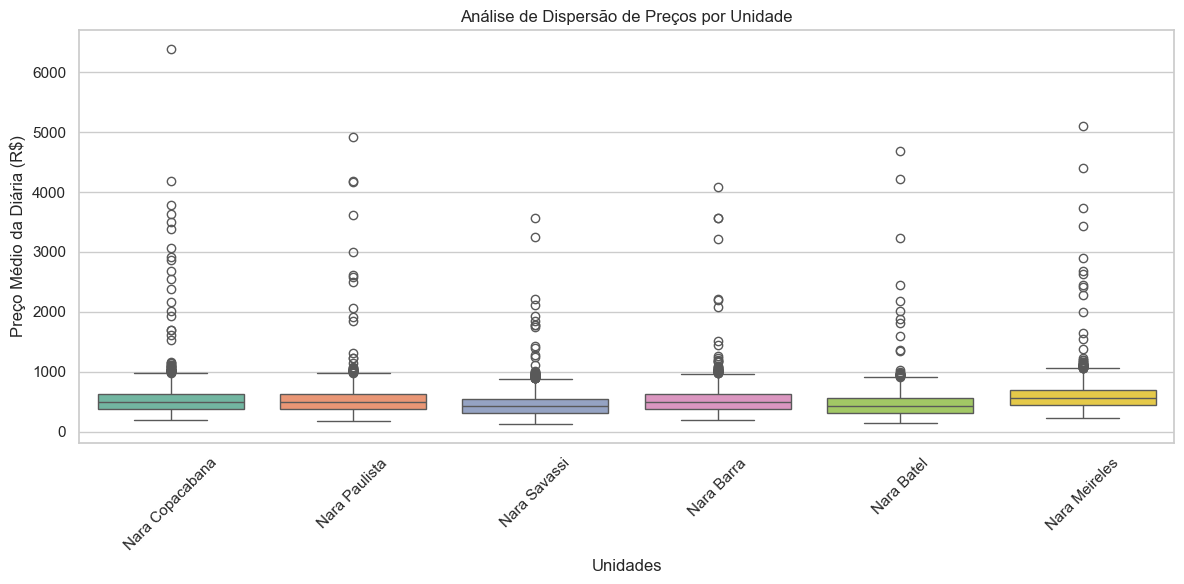

In [63]:
plt.figure()

sns.boxplot(
    x='nome',
    y='adr_estimado',
    data=df_conferencia,
    hue='nome',
    palette='Set2',
    legend=False
)

plt.title('Análise de Dispersão de Preços por Unidade')
plt.xlabel('Unidades')
plt.ylabel('Preço Médio da Diária (R$)')

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('grafico_2_outliers.png')
plt.show()


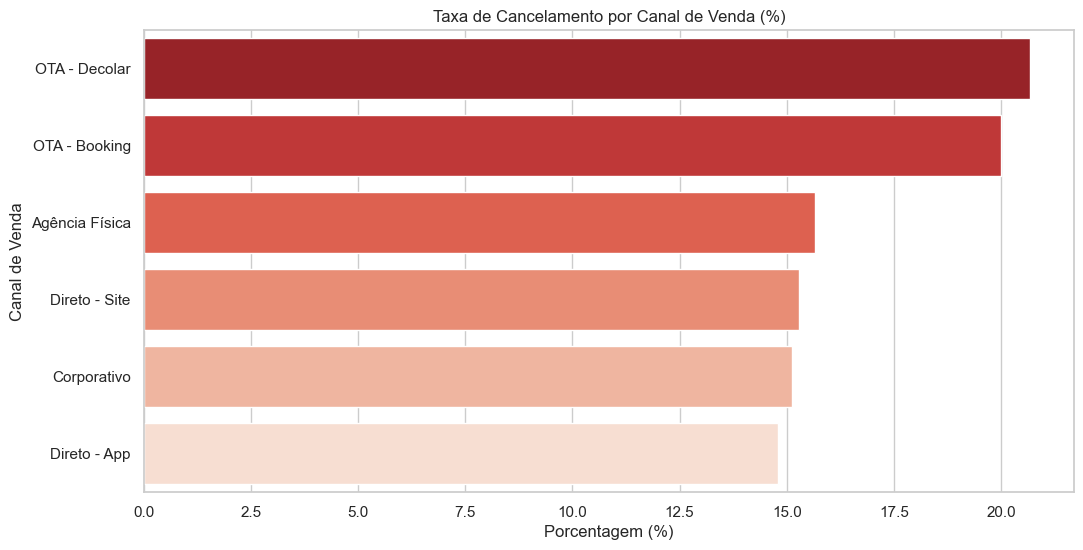

In [64]:
# 3. Taxa de Cancelamento (Ajustado: hue='canal_nome' remove o aviso)
df_canais_nomes = pd.merge(f_reservas, d_canal, on='canal_id')
taxa_canc = df_canais_nomes.groupby('canal_nome')['status'].apply(lambda x: (x == 'Cancelada').mean() * 100).reset_index()

plt.figure()
sns.barplot(x='status', y='canal_nome', data=taxa_canc.sort_values('status', ascending=False), hue='canal_nome', palette='Reds_r', legend=False)
plt.title('Taxa de Cancelamento por Canal de Venda (%)')
plt.xlabel('Porcentagem (%)')
plt.ylabel ('Canal de Venda')
plt.savefig('grafico_3_cancelamento.png')

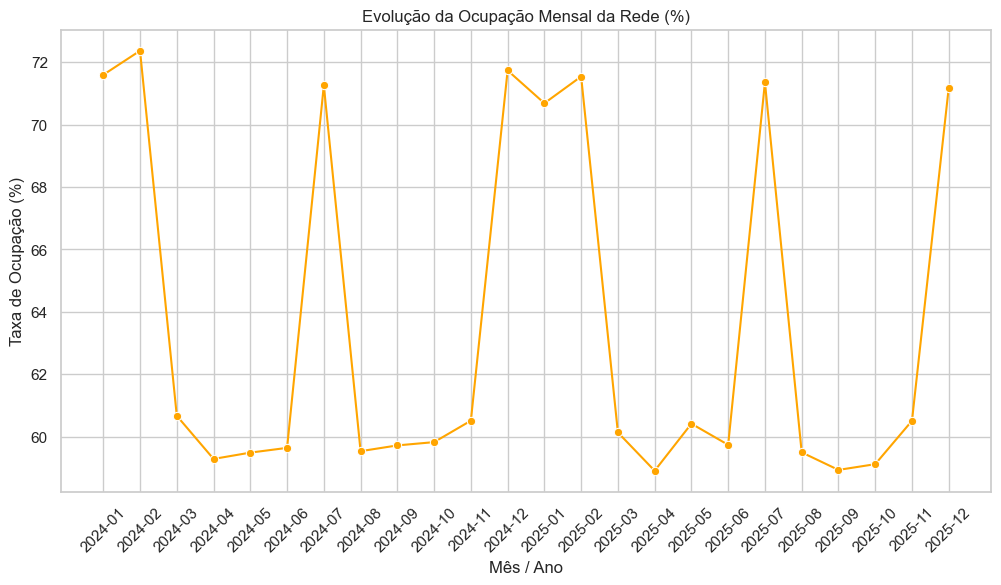

In [65]:
# 4. Evolução da Ocupação (Ajustado: include_groups=False remove o aviso do groupby)
df_conferencia['mes_ano'] = df_conferencia['data_id'].apply(formatar_data_humana).dt.to_period('M').astype(str)
ocupacao_mensal = df_conferencia.groupby('mes_ano').apply(
    lambda x: (x['quartos_vendidos'].sum() / x['quartos_disponiveis'].sum()) * 100, 
    include_groups=False
).reset_index(name='taxa')

plt.figure()
sns.lineplot(x='mes_ano', y='taxa', data=ocupacao_mensal, marker='o', color='orange')
plt.title('Evolução da Ocupação Mensal da Rede (%)')
plt.xlabel('Mês / Ano')
plt.ylabel('Taxa de Ocupação (%)')
plt.xticks(rotation=45)
plt.savefig('grafico_4_ocupacao.png')

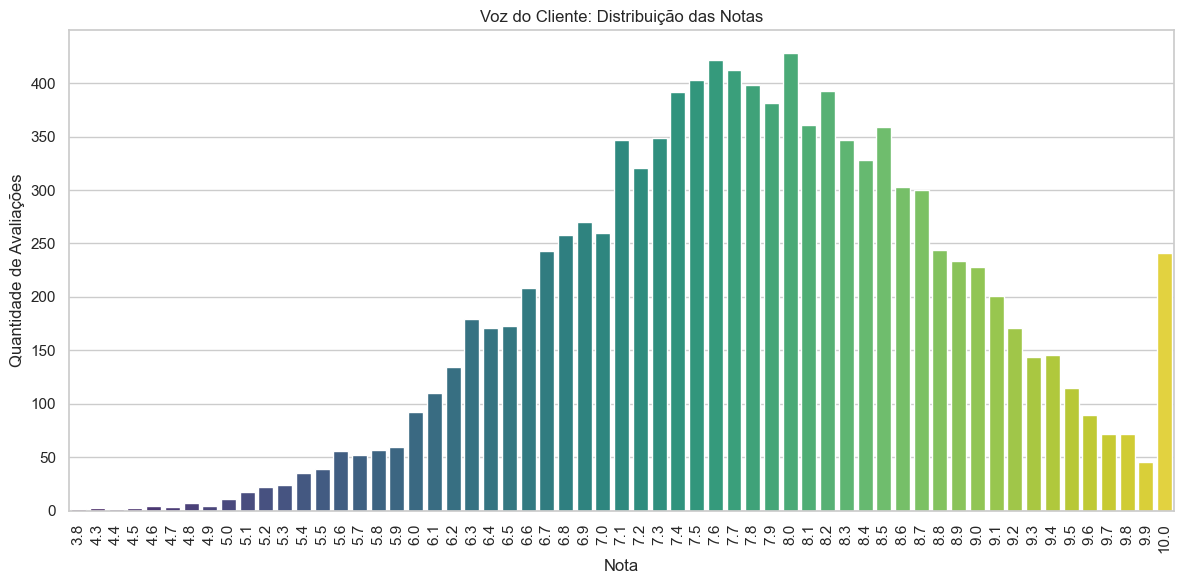

In [66]:
plt.figure()
sns.countplot(x='nota', data=f_reviews, hue='nota', palette='viridis', legend=False)

plt.title('Voz do Cliente: Distribuição das Notas')
plt.xlabel('Nota')
plt.ylabel('Quantidade de Avaliações')

# Rotaciona os valores do eixo X para ficarem legíveis
plt.xticks(rotation=90)

plt.tight_layout()  # ajusta espaçamento automaticamente
plt.savefig('grafico_5_satisfacao.png')
plt.show()


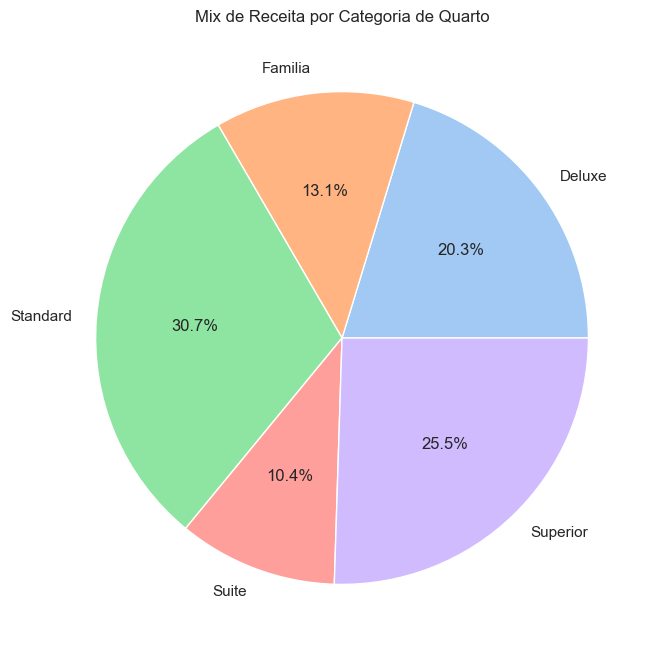

In [67]:
# 6. Composição da Receita
receita_quarto = f_diarias.groupby('tipo_quarto')['receita_diarias'].sum()
plt.figure(figsize=(8, 8))
plt.pie(receita_quarto, labels=receita_quarto.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
plt.title('Mix de Receita por Categoria de Quarto')
plt.savefig('grafico_6_receita.png')